In [1]:
import os
import random
from shutil import copyfile


import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from keras.datasets import mnist
from keras.datasets import fashion_mnist

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import itertools

%matplotlib inline
%reload_ext nb_black

Using TensorFlow backend.


<IPython.core.display.Javascript object>

In [2]:
TRAINING_DATASET_PATH = "rock_paper_scissor_dataset/training/rps/"
TESTING_DATASET_PATH = "rock_paper_scissor_dataset/testing/rps-test-set/"

<IPython.core.display.Javascript object>

In [3]:
TARGET_IMAGE_SIZE = 150
BATCH_SIZE = 32

<IPython.core.display.Javascript object>

## Prepare Dataset

In [4]:
train_data_gen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
)

train_generator = train_data_gen.flow_from_directory(
    TRAINING_DATASET_PATH,
    target_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

validation_data_gen = ImageDataGenerator(rescale=1.0 / 255,)

validation_generator = validation_data_gen.flow_from_directory(
    TESTING_DATASET_PATH,
    target_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


<IPython.core.display.Javascript object>

## Simple Model

In [5]:
def create_simple_conv_model():

    model = keras.Sequential()

    model.add(
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            activation="relu",
            input_shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3),
        )
    )
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"))
    model.add(keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(units=512, activation="relu"))
    model.add(keras.layers.Dense(units=256, activation="relu"))
    model.add(keras.layers.Dense(units=3, activation="softmax"))

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

<IPython.core.display.Javascript object>

In [6]:
simple_conv_model = create_simple_conv_model()

<IPython.core.display.Javascript object>

In [7]:
early_stopping = keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy")

<IPython.core.display.Javascript object>

In [8]:
simple_conv_model_history = simple_conv_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 79 steps, validate for 12 steps
Epoch 1/15
79/79 [==============================] - 25s 315ms/step - loss: 1.0167 - accuracy: 0.5040 - val_loss: 0.3914 - val_accuracy: 0.9301
Epoch 2/15
79/79 [==============================] - 26s 333ms/step - loss: 0.6013 - accuracy: 0.7437 - val_loss: 0.2945 - val_accuracy: 0.9005
Epoch 3/15
79/79 [==============================] - 27s 340ms/step - loss: 0.3935 - accuracy: 0.8425 - val_loss: 0.1226 - val_accuracy: 0.9785
Epoch 4/15
79/79 [==============================] - 28s 350ms/step - loss: 0.2879 - accuracy: 0.8909 - val_loss: 0.0648 - val_accuracy: 0.9919
Epoch 5/15
79/79 [==============================] - 27s 347ms/step - loss: 0.2259 - accuracy: 0.9194 - val_loss: 0.1604 - val_accuracy: 0.9220
Epoch 6/15
79/79 [==============================] - 27s 348ms/step - loss: 0.1841 - accuracy: 0.9373 - val_loss: 0.0836 - val_accuracy: 0.9570
Epoch 7/15
79/79 [==============================] 

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Loss Train vs Validation')

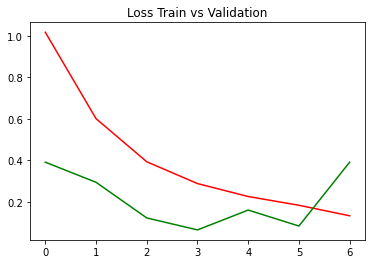

<IPython.core.display.Javascript object>

In [9]:
plt.plot(
    simple_conv_model_history.epoch,
    simple_conv_model_history.history["loss"],
    "r-",
    label="Training",
)
plt.plot(
    simple_conv_model_history.epoch,
    simple_conv_model_history.history["val_loss"],
    "g-",
    label="Validation",
)

plt.title("Loss Train vs Validation")

Text(0.5, 1.0, 'Accuracy Train vs Validation')

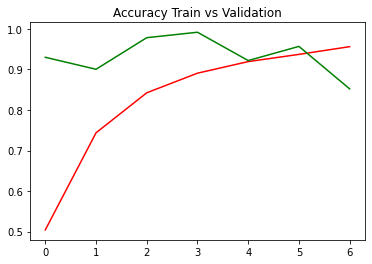

<IPython.core.display.Javascript object>

In [10]:
plt.plot(
    simple_conv_model_history.epoch,
    simple_conv_model_history.history["accuracy"],
    color="r",
)
plt.plot(
    simple_conv_model_history.epoch,
    simple_conv_model_history.history["val_accuracy"],
    color="g",
)

plt.title("Accuracy Train vs Validation")

## Transfer Learning

In [11]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

<IPython.core.display.Javascript object>

In [12]:
pretrained_model = InceptionV3(
    include_top=False,
    weights=None,
    input_shape=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE, 3),
)

<IPython.core.display.Javascript object>

In [13]:
pretrained_model.load_weights(
    "../week_3/pretrained_model/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
)

<IPython.core.display.Javascript object>

In [15]:
for layers in pretrained_model.layers:
    layers.trainable = False

<IPython.core.display.Javascript object>

In [16]:
last_layer = pretrained_model.get_layer("mixed2")

<IPython.core.display.Javascript object>

In [17]:
def get_transfered_model():

    output_layer = keras.layers.Flatten()(last_layer.output)

    output_layer = keras.layers.Dense(units=512, activation="relu")(output_layer)
    output_layer = keras.layers.Dropout(rate=0.4)(output_layer)

    output_layer = keras.layers.Dense(units=3, activation="softmax")(output_layer)

    model = keras.Model(inputs=pretrained_model.input, outputs=output_layer)

    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

    return model

<IPython.core.display.Javascript object>

In [18]:
transfer_model = get_transfered_model()

<IPython.core.display.Javascript object>

In [19]:
transfer_model_history = transfer_model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    callbacks=[early_stopping],
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 79 steps, validate for 12 steps
Epoch 1/15
79/79 [==============================] - 36s 455ms/step - loss: 7.2103 - accuracy: 0.5619 - val_loss: 0.6045 - val_accuracy: 0.8387
Epoch 2/15
79/79 [==============================] - 36s 452ms/step - loss: 0.4796 - accuracy: 0.8032 - val_loss: 0.5148 - val_accuracy: 0.7581
Epoch 3/15
79/79 [==============================] - 37s 468ms/step - loss: 0.3268 - accuracy: 0.8758 - val_loss: 0.6014 - val_accuracy: 0.7204
Epoch 4/15
79/79 [==============================] - 38s 484ms/step - loss: 0.2701 - accuracy: 0.8968 - val_loss: 0.5570 - val_accuracy: 0.7419


<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Loss Train vs Validation')

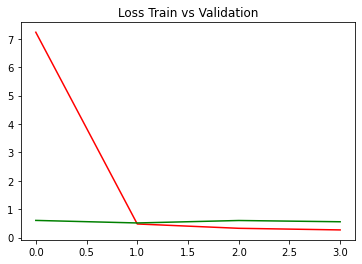

<IPython.core.display.Javascript object>

In [20]:
plt.plot(
    transfer_model_history.epoch,
    transfer_model_history.history["loss"],
    "r-",
    label="Training",
)
plt.plot(
    transfer_model_history.epoch,
    transfer_model_history.history["val_loss"],
    "g-",
    label="Validation",
)

plt.title("Loss Train vs Validation")

Text(0.5, 1.0, 'Accuracy Train vs Validation')

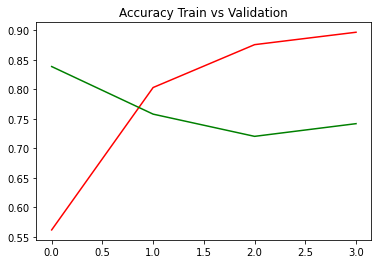

<IPython.core.display.Javascript object>

In [21]:
plt.plot(
    transfer_model_history.epoch, transfer_model_history.history["accuracy"], color="r",
)
plt.plot(
    transfer_model_history.epoch,
    transfer_model_history.history["val_accuracy"],
    color="g",
)

plt.title("Accuracy Train vs Validation")

## Prediction

In [22]:
import random

<IPython.core.display.Javascript object>

In [23]:
random.seed(42)

<IPython.core.display.Javascript object>

In [24]:
prediction_data_path = "rock_paper_scissor_dataset/prediction/"

<IPython.core.display.Javascript object>

In [25]:
def postporcess_preciction(prediction: int):
    classes = {0: "paper", 1: "rock", 2: "scissors"}
    print("Prediction is: %s" % (classes[prediction]))

<IPython.core.display.Javascript object>

In [26]:
def preprocess_image(prediction_file: str):

    print("Preprocessing", prediction_file)
    img = keras.preprocessing.image.load_img(
        os.path.join(prediction_data_path, prediction_file),
        target_size=(TARGET_IMAGE_SIZE, TARGET_IMAGE_SIZE),
    )

    x = keras.preprocessing.image.img_to_array(img)

    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])

    images /= 255

    return images

<IPython.core.display.Javascript object>

In [54]:
prediction_files = os.listdir(prediction_data_path)
prediction_file = random.choice(prediction_files)
prediction_image = preprocess_image(prediction_file)

Preprocessing paper9.png


<IPython.core.display.Javascript object>

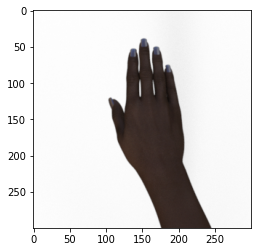

<IPython.core.display.Javascript object>

In [55]:
plt.imshow(plt.imread(os.path.join(prediction_data_path, prediction_file)))
plt.show()

In [56]:
predicted_value = simple_conv_model.predict_classes(prediction_image)

<IPython.core.display.Javascript object>

In [57]:
postporcess_preciction(predicted_value[0])

Prediction is: scissors


<IPython.core.display.Javascript object>

In [58]:
postporcess_preciction(np.argmax(transfer_model.predict(prediction_image)))

Prediction is: paper


<IPython.core.display.Javascript object>